<a href="https://colab.research.google.com/github/9n0hc/2025-1_CV/blob/main/hw_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#########
# 실험A #
#########

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
#모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x, apply_softmax=False):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if apply_softmax:
            x = F.softmax(x, dim=1)
        return x

In [ ]:
#데이터 로딩
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 335kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


In [ ]:
#학습 루프 정의 함수
def train_and_evaluate(loss_fn_name='crossentropy', epochs=20, lr=0.001):
    model = MLP().to(device)

    if loss_fn_name == 'crossentropy':
        loss_fn = nn.CrossEntropyLoss()
        apply_softmax = False
    elif loss_fn_name == 'mse':
        loss_fn = nn.MSELoss()
        apply_softmax = True
    else:
        raise ValueError("Unsupported loss function")

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, apply_softmax=apply_softmax)

            if loss_fn_name == 'mse':
                target_one_hot = F.one_hot(target, num_classes=10).float()
                loss = loss_fn(output, target_one_hot)
            else:
                loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))
        test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={test_acc:.2f}%")

    return train_losses, test_accuracies

In [ ]:
#테스트 정확도 측정 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return 100. * correct / len(loader.dataset)

In [ ]:
#실험 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running CrossEntropy...")
loss_ce, acc_ce = train_and_evaluate('crossentropy')

print("\nRunning MSE+Softmax...")
loss_mse, acc_mse = train_and_evaluate('mse')

Running CrossEntropy...
Epoch 1: Loss=491.2249, Accuracy=85.64%
Epoch 2: Loss=349.5396, Accuracy=86.15%
Epoch 3: Loss=314.5329, Accuracy=86.55%
Epoch 4: Loss=289.9825, Accuracy=86.78%
Epoch 5: Loss=272.6373, Accuracy=87.15%
Epoch 6: Loss=259.0697, Accuracy=87.98%
Epoch 7: Loss=243.5188, Accuracy=88.49%
Epoch 8: Loss=235.3596, Accuracy=88.33%
Epoch 9: Loss=226.5635, Accuracy=88.14%
Epoch 10: Loss=214.9596, Accuracy=88.90%
Epoch 11: Loss=208.3970, Accuracy=88.93%
Epoch 12: Loss=200.1737, Accuracy=89.11%
Epoch 13: Loss=191.8753, Accuracy=89.18%
Epoch 14: Loss=184.5434, Accuracy=89.44%
Epoch 15: Loss=178.7201, Accuracy=88.05%
Epoch 16: Loss=171.4884, Accuracy=89.05%
Epoch 17: Loss=163.9562, Accuracy=89.00%
Epoch 18: Loss=161.3874, Accuracy=89.35%
Epoch 19: Loss=154.2448, Accuracy=88.74%
Epoch 20: Loss=149.4463, Accuracy=88.68%

Running MSE+Softmax...
Epoch 1: Loss=25.3390, Accuracy=84.02%
Epoch 2: Loss=18.6748, Accuracy=86.59%
Epoch 3: Loss=16.8674, Accuracy=87.05%
Epoch 4: Loss=15.6840, A

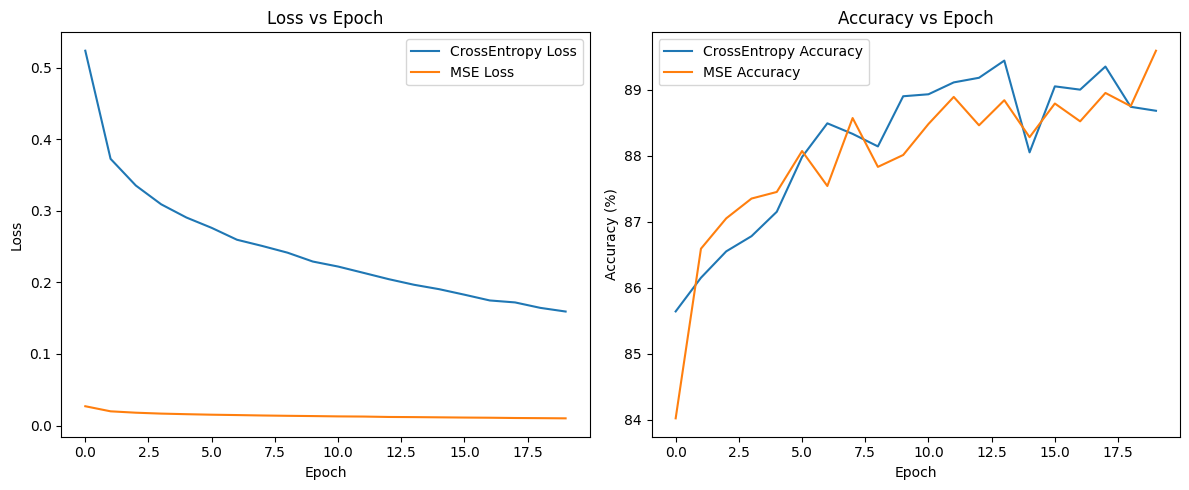

In [ ]:
#시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_ce, label='CrossEntropy Loss')
plt.plot(loss_mse, label='MSE Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_ce, label='CrossEntropy Accuracy')
plt.plot(acc_mse, label='MSE Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#########
# 실험B #
#########

In [ ]:
!pip install torch torchvision scikit-learn matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [ ]:
# 데이터셋
X_moons, y_moons = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_circles, y_circles = make_circles(n_samples=1000, noise=0.2, factor=0.5, random_state=42)

# 텐서 변환
X, y = torch.tensor(X_moons, dtype=torch.float32), torch.tensor(y_moons, dtype=torch.long)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, activation):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden1),
            activation,
            nn.Linear(hidden1, hidden2),
            activation,
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# 실험 반복문 내
# 공통
input_size = 2
hidden1, hidden2 = 256, 128
num_classes = 2
loss_fn = nn.CrossEntropyLoss()
lr = 0.01
epochs = 300

# 활성화 함수 리스트
acts = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.01),
    'Sigmoid': nn.Sigmoid()
}

results = {}
for name, act in acts.items():
    model = MLP(input_size, hidden1, hidden2, num_classes, act).to(device)
    # 가중치 초기화 (std=0.01)
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0, std=0.01)
            nn.init.constant_(m.bias, 0)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'loss': [], 'acc': [], 'dead_ratio': []}

    for epoch in range(epochs):
      model.train()
      total_loss, correct, total = 0, 0, 0
      dead_count = 0; total_neurons = 0

      for xb, yb in loader:
          xb, yb = xb.to(device), yb.to(device)
          logits = model(xb)
          loss = loss_fn(logits, yb)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item() * xb.size(0)
          preds = logits.argmax(1)
          correct += (preds == yb).sum().item()
          total += xb.size(0)

      # Dead ReLU 비율 측정 (첫 번째 레이어 출력)
      with torch.no_grad():
          out1 = acts[name](model.net[0](torch.tensor(X, device=device)))
          dead_ratio = (out1 == 0).float().mean().item() if name == 'ReLU' else 0.0

      epoch_loss = total_loss / total
      epoch_acc = correct / total
      history['loss'].append(epoch_loss)
      history['acc'].append(epoch_acc)
      history['dead_ratio'].append(dead_ratio)

      print(f"[{name}] Epoch {epoch+1:03d}: "
            f"Loss = {epoch_loss:.4f}, "
            f"Acc = {epoch_acc:.4f}, "
            f"Dead ReLU Ratio = {dead_ratio*100:.2f}%")


    results[name] = history

<ipython-input-30-2162070e2730>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out1 = acts[name](model.net[0](torch.tensor(X, device=device)))


[ReLU] Epoch 001: Loss = 0.4596, Acc = 0.7790, Dead ReLU Ratio = 47.56%
[ReLU] Epoch 002: Loss = 0.3007, Acc = 0.8690, Dead ReLU Ratio = 57.23%
[ReLU] Epoch 003: Loss = 0.2818, Acc = 0.8720, Dead ReLU Ratio = 60.04%
[ReLU] Epoch 004: Loss = 0.2514, Acc = 0.8920, Dead ReLU Ratio = 58.71%
[ReLU] Epoch 005: Loss = 0.2196, Acc = 0.9100, Dead ReLU Ratio = 58.16%
[ReLU] Epoch 006: Loss = 0.1469, Acc = 0.9420, Dead ReLU Ratio = 57.94%
[ReLU] Epoch 007: Loss = 0.1026, Acc = 0.9590, Dead ReLU Ratio = 57.93%
[ReLU] Epoch 008: Loss = 0.0946, Acc = 0.9660, Dead ReLU Ratio = 58.80%
[ReLU] Epoch 009: Loss = 0.0887, Acc = 0.9650, Dead ReLU Ratio = 60.37%
[ReLU] Epoch 010: Loss = 0.0671, Acc = 0.9740, Dead ReLU Ratio = 60.45%
[ReLU] Epoch 011: Loss = 0.0804, Acc = 0.9710, Dead ReLU Ratio = 61.69%
[ReLU] Epoch 012: Loss = 0.0781, Acc = 0.9750, Dead ReLU Ratio = 63.28%
[ReLU] Epoch 013: Loss = 0.0793, Acc = 0.9710, Dead ReLU Ratio = 64.07%
[ReLU] Epoch 014: Loss = 0.1003, Acc = 0.9650, Dead ReLU Ratio =

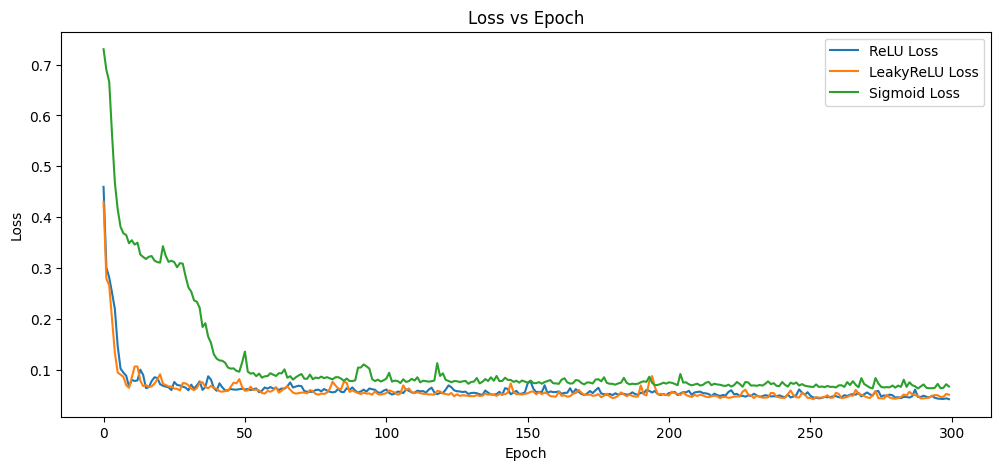

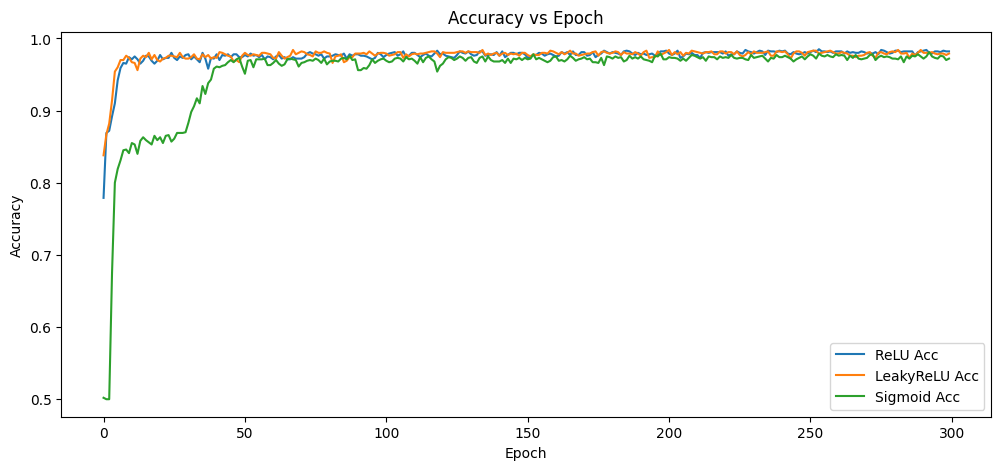

In [ ]:
# 시각화
plt.figure(figsize=(12,5))
for name, h in results.items():
    plt.plot(h['loss'], label=f"{name} Loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(); plt.show()

plt.figure(figsize=(12,5))
for name, h in results.items():
    plt.plot(h['acc'], label=f"{name} Acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(); plt.show()